# Image Colorization with U-Net and GAN 

## 1 — Implementing the paper — Our Baseline

### 1.1- Loading Image Paths


In [6]:
class Config:
    external_data_size = 10000
    train_size = 8000
    image_size_1 = 256
    image_size_2 = 256
    batch_size = 32
    LeakyReLU_slope = 0.2
    dropout = 0.5
    kernel_size = 4
    stride = 2
    padding = 1
    gen_lr = 2e-4
    disc_lr = 2e-4
    beta1 = 0.5
    beta2 = 0.999
    lambda_l1 = 100
    gan_mode = 'vanilla'
    layers_to_cut = -2
    epochs = 2
    pretrain_lr = 1e-4

In [7]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
Path.ls = lambda x: list(x.iterdir())

import PIL
from PIL import Image

import torch
from torch import nn, optim
from torch import nn, optim
from torchvision import transforms
from torchvision.models.resnet import resnet18
from torchvision.models.vgg import vgg19
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.hub import load_state_dict_from_url

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
!pip install fastai==2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.9/187.9 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 871.7 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.5.27
    Uninstalling fastcore-1.5.27:
      Successfully uninstalled fastcore-1.5.27
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.9
    Uninstalling fastai-2.7.9:
      Successfully uninstalled fastai-2.7.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires torch<1.13.0,>=1.10.0, but you have torch 1.9.1 which is incompatible.


In [9]:
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

In [10]:
!pip install torch torchvision==0.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 13.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.8/748.8 MB 1.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.7.7 requires torch>=1.9.*, but you have torch 1.6.0 which is incompatible.
fastai 2.4 requires torch<1.10,>=1.7.0, but you have torch 1.6.0 which is incompatible.
fastai 2.4 requires torchvision>=0.8.2, but you have torchvision 0.7.0 which is incompatible.
fairscale 0.4.6 requires torch>=1.8.0, but yo

In [11]:
from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet
# from fastai.vision.all import *
# from fastai.text.all import *
# from fastai.collab import *
# from fastai.tabular.all import *

In [12]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [13]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"
    
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


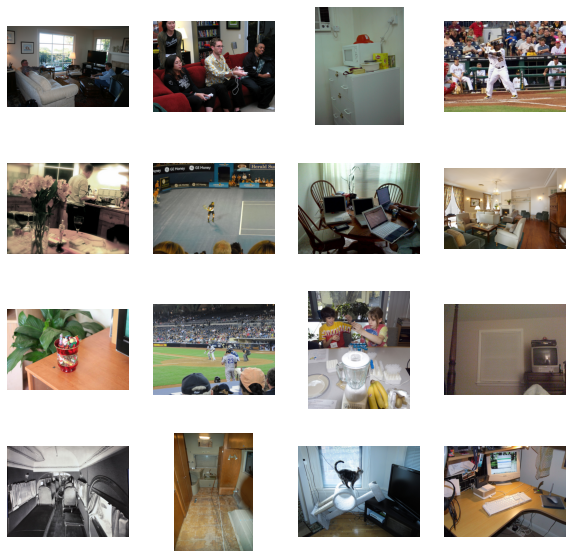

In [14]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### 1.2- Making Datasets and DataLoaders

In [15]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.Resampling.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.Resampling.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

In [16]:
def make_dataloaders(batch_size=16,
                     n_workers=2,
                     pin_memory=True,
                     **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [17]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  """


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


### 1.3- Generator proposed by the paper

In [18]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

### 1.4- Discriminator

In [19]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [20]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [21]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

### 1.5- GAN Loss

In [22]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### 1.x Model Initialization

In [23]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

### 1.6- Putting everything together

In [24]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### 1.xx Utility functions

In [25]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [26]:
def build_backbone_unet(input_channels=1, output_channels=2, size=Config.image_size_1):
    """Function that helps build the generator backbone using another pretrained model trained on imagenet for image classification"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=input_channels, cut=Config.layers_to_cut)
    generator = DynamicUnet(body, output_channels, (size, size)).to(device)
    return generator

def pretrain_generator(generator, train_dl, opt, criterion, epochs):
    """

    Function to pretrain the generator in a supervised manner on the colorization task using L1 Loss.

    """

    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = generator(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

### 1.7- Training function

In [27]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

In [28]:
generator = build_backbone_unet(input_channels=1, output_channels=2, size=Config.image_size_1)
opt = optim.Adam(generator.parameters(), lr=Config.pretrain_lr)
loss = nn.L1Loss()
pretrain_generator(generator, train_dl, opt, loss, Config.epochs)
torch.save(generator.state_dict(), "res18-unet.pt")
generator.load_state_dict(torch.load("res18-unet.pt", map_location=device))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/2
L1 Loss: 0.08540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/2
L1 Loss: 0.08312


<All keys matched successfully>

model initialized with norm initialization


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1/2
Iteration 200/500
loss_D_fake: 0.48879
loss_D_real: 0.49509
loss_D: 0.49194
loss_G_GAN: 1.56428
loss_G_L1: 9.35513
loss_G: 10.91941


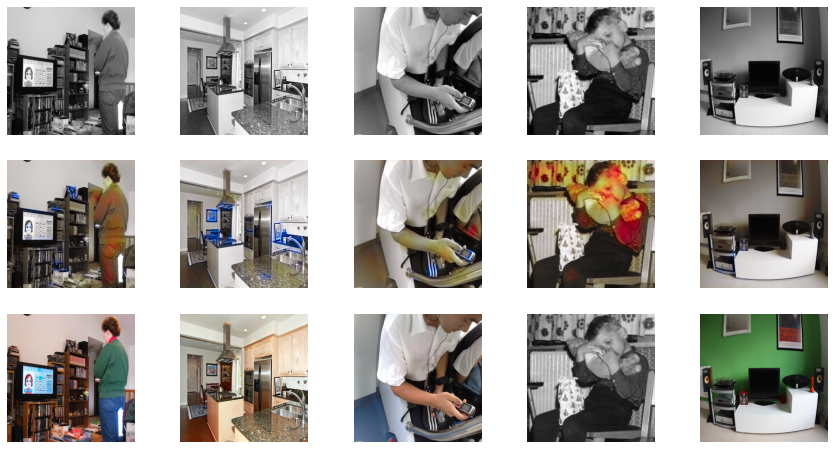


Epoch 1/2
Iteration 400/500
loss_D_fake: 0.44891
loss_D_real: 0.47057
loss_D: 0.45974
loss_G_GAN: 1.74778
loss_G_L1: 9.46236
loss_G: 11.21014


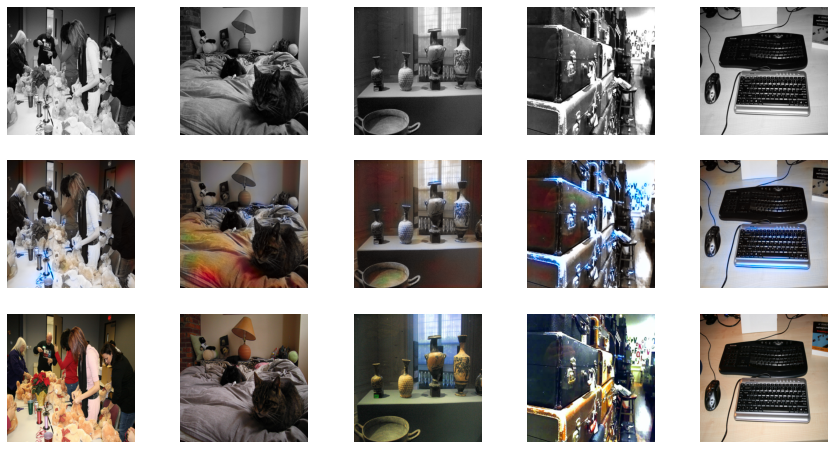

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 2/2
Iteration 200/500
loss_D_fake: 0.51702
loss_D_real: 0.54929
loss_D: 0.53316
loss_G_GAN: 1.41901
loss_G_L1: 10.31020
loss_G: 11.72921


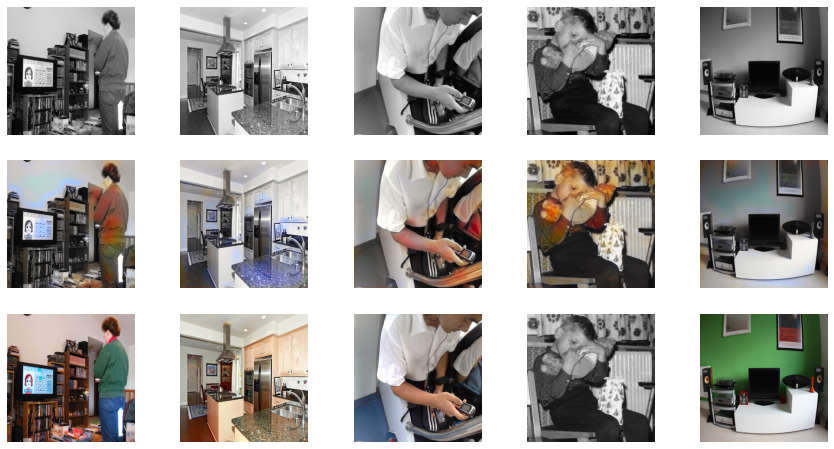


Epoch 2/2
Iteration 400/500
loss_D_fake: 0.51655
loss_D_real: 0.55731
loss_D: 0.53693
loss_G_GAN: 1.36877
loss_G_L1: 10.23653
loss_G: 11.60530


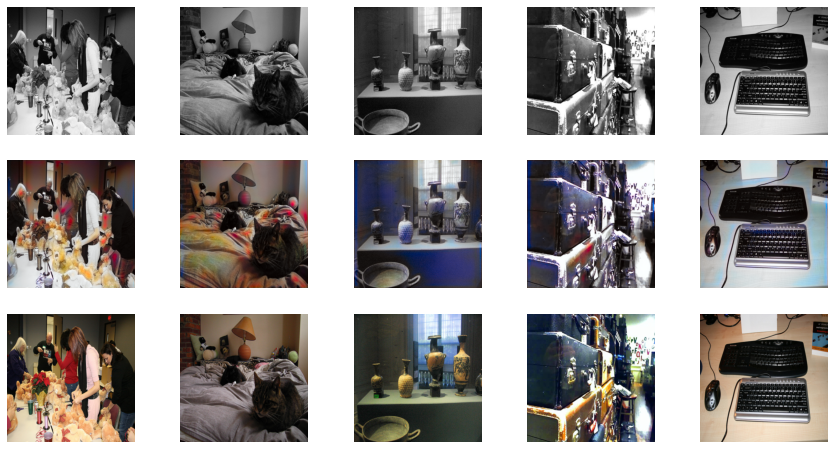

In [29]:
model = MainModel(net_G=generator)
train_model(model, train_dl, Config.epochs)
torch.save(model.state_dict(), "main-model.pt")

### 1.8 Model Inference

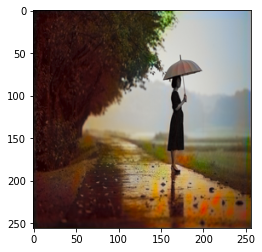

In [32]:
path = "/kaggle/input/pip2pix-data2/test_image.jpeg"
img = PIL.Image.open(path)
img = img.resize((256, 256))
img = transforms.ToTensor()(img)[:1] * 2. - 1.
model.eval()
with torch.no_grad():
    preds = model.net_G(img.unsqueeze(0).to(device))
    gen_output = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
# plt.imshow(img)
plt.imshow(gen_output)

In [33]:
torch.save(model.state_dict(), "main-model.hdf5")

In [34]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 16.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 40.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.2 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=7fd0e928dbf45248de088287d3ef0630283ef7ff9146392f26e4ae51803d332d
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


In [37]:
%%writefile webapp.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import cv2
from PIL import Image, ImageOps
import numpy as np

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation= True)
def load_model():
#     model.load_state_dict(torch.load('/kaggle/input/pip2pix-data2/main-model.pt'))
#     return model
    model = tf.keras.models.load_model('/kaggle/input/pip2pix-data2/main-model.hdf5')
    return model 

with st.spinner('Model is being loaded...'):
    model = load_model()
st.write("""
        # Image Recolorisation
        """
        )
file = st.file_uploader("Please upload an image", type=["jpg","png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
def import_and_predict (image_data, model):
    size = (256, 256)
    image = ImageOps. fit (image_data, size, Image.ANTIALIAS)
    img = np.asarray (image)
    img_reshape = img[np.newaxis , ...]
    prediction = model.predict (img_reshape)
    
    return prediction

if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open (file)
    st.image (image, use_column_width=True)
    predictions = import_and_predict(image, model)
    string="This image most likely is: "+ [np.argmax (predictions)]
    st.success(string)

Overwriting webapp.py


In [39]:
file = st.file_uploader("Please upload an image", type=["jpg","png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
def import_and_predict (image_data, model):
    size = (256, 256)
    image = ImageOps. fit (image_data, size, Image.ANTIALIAS)
    img = np.asarray (image)
    img_reshape = img[np.newaxis , ...]
    prediction = model.predict (img_reshape)
    
    return prediction

if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open (file)
    st.image (image, use_column_width=True)
    predictions = import_and_predict(image, model)
    string="This image most likely is: "+ [np.argmax (predictions)]
    st.success(string)

NameError: name 'st' is not defined